In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from models.HFR import HFRRes3D
from metrics.metrics import mse_dimwise, nrmse_dimwise, compute_valid_prediction_time, compute_attractor_deviation, compute_relative_psd
import json
import itertools
from tqdm import tqdm

In [5]:
def lorenz_deriv(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x*(rho - z) - y
    dzdt = x*y - beta*z
    return [dxdt, dydt, dzdt]

def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    num_steps = int(tmax / dt) + 1 # +1 to include t=0
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_deriv, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

In [6]:
def compute_valid_prediction_time(y_true, y_pred, t_vals, threshold, lambda_max, dt):
    """
    Compute the Valid Prediction Time (VPT) and compare it to Lyapunov time T_lambda = 1 / lambda_max.
    
    Parameters
    ----------
    y_true : ndarray of shape (N, dim)
        True trajectory over time.
    y_pred : ndarray of shape (N, dim)
        Model's predicted trajectory over time (closed-loop).
    t_vals : ndarray of shape (N,)
        Time values corresponding to the trajectory steps.
    threshold : float, optional
        The error threshold, default is 0.4 as in your snippet.
    lambda_max : float, optional
        Largest Lyapunov exponent. Default=0.9 for Lorenz.
        
    Returns
    -------
    T_VPT : float
        Valid prediction time. The earliest time at which normalized error surpasses threshold
        (or the last time if never surpassed).
    T_lambda : float
        Lyapunov time = 1 / lambda_max
    ratio : float
        How many Lyapunov times the model prediction remains valid, i.e. T_VPT / T_lambda.
    """
    # 1) Average of y_true
    y_mean = np.mean(y_true, axis=0)  # shape (dim,)
    
    # 2) Time-averaged norm^2 of (y_true - y_mean)
    y_centered = y_true - y_mean
    denom = np.mean(np.sum(y_centered**2, axis=1))  # scalar
    
    # 3) Compute the normalized error delta_gamma(t) = ||y_true - y_pred||^2 / denom
    diff = y_true - y_pred
    err_sq = np.sum(diff**2, axis=1)  # shape (N,)
    delta_gamma = err_sq / denom      # shape (N,)
    
    # 4) Find the first time index where delta_gamma(t) exceeds threshold
    idx_exceed = np.where(delta_gamma > threshold)[0]
    if len(idx_exceed) == 0:
        # never exceeds threshold => set T_VPT to the final time
        T_VPT = t_vals[-1]
    else:
        T_VPT = t_vals[idx_exceed[0]]
    
    # 5) Compute T_lambda and ratio
    T_lambda = 1.0 / lambda_max

    # print(f"\n--- Valid Prediction Time (VPT) with threshold={threshold}, lambda_max={lambda_max} ---")

    T_VPT = (T_VPT - t_vals[0])  # Adjust T_VPT to be relative to the start time
    ratio = T_VPT / T_lambda

    return T_VPT, T_lambda, ratio

In [7]:
def report_vpt(name, preds, test_target, time_test, dt):
    T_VPT, T_lambda, ratio = compute_valid_prediction_time(
        test_target, preds, time_test, threshold=0.4, lambda_max=0.9, dt=dt
    )
    # print(f"{name:20s} => T_VPT={T_VPT:.3f},  T_lambda={T_lambda:.3f}, ratio={ratio:.3f}")
    return T_VPT, T_lambda, ratio

In [8]:
# 1) Generate Lorenz data
tmax = 250
dt   = 0.02
t_vals, lorenz_traj = generate_lorenz_data(
    initial_state=[1.0,1.0,1.0],
    tmax=tmax,
    dt=dt
)

washout = 2000
t_vals = t_vals[washout:]
lorenz_traj = lorenz_traj[washout:]

# normalize
scaler = StandardScaler()
scaler.fit(lorenz_traj)
lorenz_traj = scaler.transform(lorenz_traj)

T_data = len(lorenz_traj)
print(f"Data length: {T_data}, from t=0..{tmax} with dt={dt}.")

n_test_steps = 2100

# train/test split
train_frac = 0.8
train_end = int(train_frac*(T_data-1))
train_input  = lorenz_traj[:train_end]
train_target = lorenz_traj[1:train_end+1]
test_input   = lorenz_traj[train_end:train_end+n_test_steps]
test_target  = lorenz_traj[train_end+1:train_end+n_test_steps+1]
print(f"Train size: {len(train_input)}  Test size: {len(test_input)}")

initial_in = test_input[0]

Data length: 10501, from t=0..250 with dt=0.02.
Train size: 8400  Test size: 2100


In [ ]:
def scale_spectral_radius(W, target_radius=0.95):
    """
    Scales a matrix W so that its largest eigenvalue magnitude = target_radius.
    """
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

def augment_state_with_squares(x):
    """
    Given state vector x in R^N, return [ x, x^2, 1 ] in R^(2N+1).
    We'll use this for both training and prediction.
    """
    x_sq = x**2
    return np.concatenate([x, x_sq, [1.0]])  # shape: 2N+1

class HFRRes3D:
    """
    Hierarchical Fractal Reservoir (HFR) for 3D chaotic systems.
    
    This novel reservoir architecture partitions the chaotic attractor at multiple
    hierarchical scales, combining them in a fractal-like adjacency structure.
    The method is model-free, relying solely on the observed trajectory in R^3,
    and does not require knowledge of any system parameters such as sigma, rho, beta
    for Lorenz63. 
    
    Key Idea:
     1) Define multiple 'scales' of partition of the data's bounding region.
     2) Each scale is subdivided into a certain number of cells (regions).
     3) Each cell at level l has links to both:
        - other cells at the same level (horizontal adjacency),
        - 'child' cells at the finer level l+1 (vertical adjacency).
     4) We gather all cells across levels => a multi-level fractal graph => adjacency => W.
     5) We build a typical ESN from this adjacency, feed data with W_in, run leaky tanh updates,
        then do a polynomial readout for 3D next-step prediction.

    This approach is suitable for chaotic systems whose attractors often exhibit fractal
    self-similarity, thus capturing multi-scale structures in a single reservoir.
    """

    def __init__(self,
                 n_levels=3,             # number of hierarchical levels
                 cells_per_level=None,   # list of number of cells at each level, e.g. [8, 32, 128]
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        Parameters
        ----------
        n_levels       : int, number of hierarchical scales
        cells_per_level: list[int], the number of partitions/cells at each level
                         if None, we auto-generate e.g. 2^(level+2)
        spectral_radius: final scaling for adjacency
        input_scale    : random input scale W_in
        leaking_rate   : ESN leaky alpha
        ridge_alpha    : readout ridge penalty
        seed           : random seed
        """
        self.n_levels        = n_levels
        self.cells_per_level = cells_per_level
        self.spectral_radius = spectral_radius
        self.input_scale     = input_scale
        self.leaking_rate    = leaking_rate
        self.ridge_alpha     = ridge_alpha
        self.seed            = seed

        if self.cells_per_level is None:
            # default scheme e.g. 8, 16, 32 for 3 levels
            self.cells_per_level = [8*(2**i) for i in range(n_levels)]

        # We'll store adjacency W, input W_in, readout W_out, reservoir state x
        self.W     = None
        self.W_in  = None
        self.W_out = None
        self.x     = None
        self.n_levels = len(self.cells_per_level)

        # We'll define a total number of nodes = sum(cells_per_level)
        self.n_nodes = sum(self.cells_per_level)

    def _build_partitions(self, data_3d):
        """
        Build hierarchical partitions for each level.
        We'll store the bounding box for data_3d, then for each level l in [0..n_levels-1]
        run e.g. k-means with K = cells_per_level[l], each point gets a label => we track transitions.

        Return: 
          partitions => list of arrays, partitions[l] => shape (N, ) cluster assignment in [0..cells_per_level[l]-1]
        """
        from sklearn.cluster import KMeans
        N = len(data_3d)
        partitions = []

        for level in range(self.n_levels):
            k = self.cells_per_level[level]
            # cluster
            kmeans = KMeans(n_clusters=k, random_state=self.seed+10*level, n_init='auto')
            kmeans.fit(data_3d)
            labels = kmeans.predict(data_3d)
            partitions.append(labels)

        return partitions

    def _build_hierarchical_adjacency(self, data_3d):
        """
        Build a block adjacency with cross-level links, then scale spectral radius.
        Steps:
          1) Build partitions for each level => partitions[l] in [0..cells_per_level[l]-1]
          2) For each level l, build a transition matrix T_l of shape (cells_per_level[l], cells_per_level[l]).
          3) Link scale l to scale l+1 by figuring out which cluster i at scale l maps to which cluster j at scale l+1
             for each sample t => link i-> j if data_3d[t] is in i at scale l and j at scale l+1.
          4) Combine all transitions in one big adjacency W in R^(n_nodes x n_nodes).
          5) row-normalize W => scale largest eigenvalue => spectral_radius
        """
        partitions = self._build_partitions(data_3d)
        N = len(data_3d)

        # offsets for each level => to index big W
        offsets = []
        running = 0
        for level in range(self.n_levels):
            offsets.append(running)
            running += self.cells_per_level[level]

        # total nodes
        n_tot = self.n_nodes
        # initialize adjacency
        A = np.zeros((n_tot, n_tot))

        # 1) horizontal adjacency in each level
        for level in range(self.n_levels):
            k = self.cells_per_level[level]
            labels = partitions[level]
            # T_l => shape (k, k)
            T_l = np.zeros((k, k))
            for t in range(N-1):
                i = labels[t]
                j = labels[t+1]
                T_l[i,j]+=1
            # row normalize
            row_sum = T_l.sum(axis=1, keepdims=True)
            row_sum[row_sum==0.0] = 1.0
            T_l /= row_sum
            # place T_l into big A
            off = offsets[level]
            A[off:off+k, off:off+k] = T_l

        # 2) vertical adjacency between scale l and l+1
        for level in range(self.n_levels-1):
            k_l   = self.cells_per_level[level]
            k_lp1 = self.cells_per_level[level+1]
            labels_l   = partitions[level]
            labels_lp1 = partitions[level+1]
            # we define adjacency from i in [0..k_l-1] to j in [0..k_lp1-1] if the same sample t belongs to i at level l and j at l+1
            # Count how many times
            Xvert1 = np.zeros((k_l, k_lp1))
            for t in range(N):
                i = labels_l[t]
                j = labels_lp1[t]
                Xvert1[i,j]+=1
            # row normalize
            row_sum = Xvert1.sum(axis=1, keepdims=True)
            row_sum[row_sum==0.0] = 1.0
            Xvert = Xvert1/row_sum
            # place in big A
            off_l   = offsets[level]
            off_lp1 = offsets[level+1]
            A[off_l:off_l+k_l, off_lp1:off_lp1+k_lp1] = Xvert
            # tentative idea, we could also define adjacency from l+1 -> l (parent link), if desired
            # we do the same for the 'child -> parent' link or skip it if we only want forward adjacency
            # For now, let's do symmetrical
            Yvert = Xvert1.T
            col_sum = Yvert.sum(axis=1, keepdims=True)
            col_sum[col_sum==0.0] = 1.0
            Yvert /= col_sum
            A[off_lp1:off_lp1+k_lp1, off_l:off_l+k_l] = Yvert

        # now we have a big adjacency => row normalize again, then scale spectral radius
        row_sum = A.sum(axis=1, keepdims=True)
        row_sum[row_sum==0.0] = 1.0
        A /= row_sum

        A = scale_spectral_radius(A, self.spectral_radius)
        return A

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Main training routine:
          1) Build hierarchical adjacency from fractal partition => self.W
          2) define W_in => shape(n_nodes, 3)
          3) teacher forcing => polynomial readout => solve => self.W_out
        """
        np.random.seed(self.seed)
        # Build adjacency
        W_big = self._build_hierarchical_adjacency(train_input)
        self.W = W_big

        # define W_in => shape(n_nodes,3)
        self.n_nodes = W_big.shape[0]
        self.W_in = (np.random.rand(self.n_nodes,3)-0.5)*2.0*self.input_scale

        # define reservoir state
        self.x = np.zeros(self.n_nodes)

        # gather states => teacher forcing => polynomial => readout
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]
        X_list= []
        for s in states_use:
            X_list.append( augment_state_with_squares(s) )
        X_aug= np.array(X_list)

        reg= Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        self.W_out= reg.coef_

    def collect_states(self, inputs, discard=100):
        """
        Teacher forcing => feed real 3D => gather states => shape => [T-discard, n_nodes].
        returns (states_after_discard, states_discarded).
        """
        self.reset_state()
        states= []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states= np.array(states)
        return states[discard:], states[:discard]

    def reset_state(self):
        if self.x is not None:
            self.x.fill(0.0)

    def _update(self, u):
        """
        x(t+1)= (1-alpha)x(t)+ alpha tanh( W*x(t)+ W_in*u(t) ).
        """
        alpha= self.leaking_rate
        pre_acts= self.W@self.x + self.W_in@u
        x_new= np.tanh(pre_acts)
        self.x= (1.0- alpha)*self.x+ alpha*x_new

    def predict_autoregressive(self, initial_input, n_steps):
        """
        fully autonomous => feed last predicted => next input
        """
        preds= []
        #self.reset_state()
        current_in= np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            big_x= augment_state_with_squares(self.x)
            out= self.W_out@big_x
            preds.append(out)
            current_in= out
        return np.array(preds)
    
    def predict_open_loop(self, test_input):
        preds = []
        for true_input in test_input:
            self._update(true_input)
            x_aug = augment_state_with_squares(self.x)
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)


In [ ]:
# # (g) Hierarchical Fractal Reservoir (HFR)
# hfr_res = HFRRes3D(
#     n_levels=3,             # number of hierarchical scales
#     cells_per_level=[50, 100, 150],   #[32, 32, 32, 32, 32, 32, 32, 32, 64],   # number of partitions at each scale (sum => total reservoir size) 
#                                                         # this config gave 11 VPT: 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64
#                                                         # this config gave 10.62 VPT: 32, 32, 32, 32, 32, 32, 32, 32, 32, 32
#                                                         # clubbing two of them let to a drop to 10.0 VPT: 32, 32, 32, 32, 32, 32, 32, 32, 64 
#                                                         # but funny part is that 320 itself is giving 12.06 VPT
#     spectral_radius=0.95,
#     input_scale=0.2,
#     leaking_rate=0.1,
#     ridge_alpha=1e-8,
#     seed=50
# )
# hfr_res.fit_readout(train_input, train_target, discard=100)

# hfr_preds = hfr_res.predict_autoregressive(initial_in, n_test_steps)

c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# mse_hfr    = mse_dimwise(hfr_preds,    test_target)
# nrmse_hfr    = nrmse_dimwise(hfr_preds,    test_target)
# print(report_vpt("HFR",         hfr_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt))
# adev_hfr = compute_attractor_deviation(hfr_preds, test_target)
# rel_psd_hfr = compute_relative_psd(test_target, hfr_preds)
# print("PSD          :",  rel_psd_hfr)
# print("ADev          :",  adev_hfr)
# print("mse      :",  mse_hfr)
# print("nrmse    :",  nrmse_hfr)

(5.840000000000003, 1.1111111111111112, 5.256000000000003)
PSD          : 1.0714738500924759
ADev          : 1321
mse      : 3.173092474677495
nrmse    : 2.3035827725036726


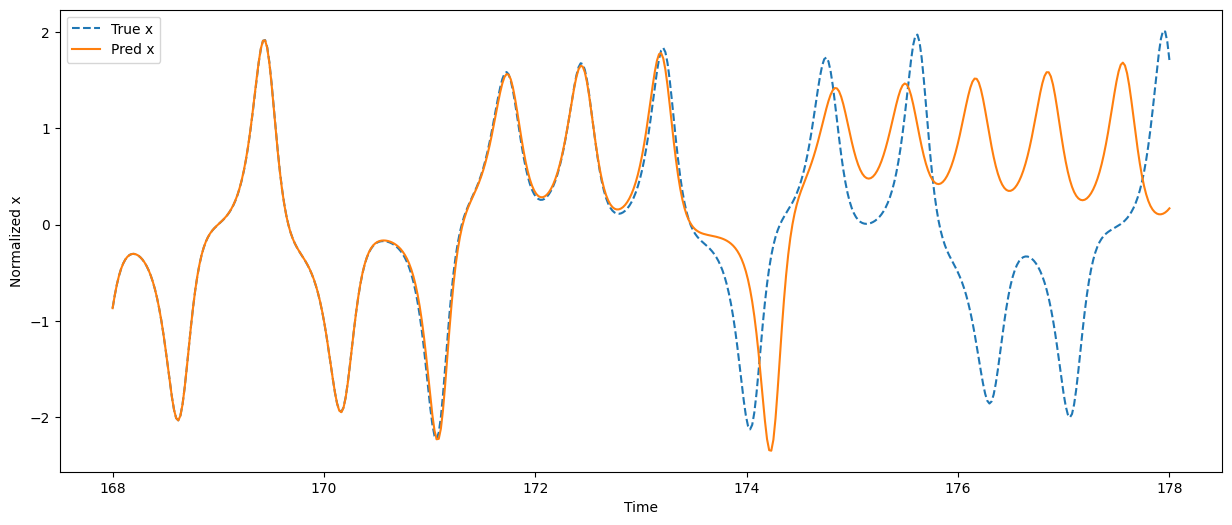

In [ ]:
# # 4) partial trajectory
# plot_len = min(500, n_test_steps)
# time_test = np.linspace(train_end*dt, (train_end+plot_len)*dt, plot_len)

# plt.figure(figsize=(15,6))
# plt.plot(time_test, test_target[:plot_len,0], label='True x', linestyle='--')
# plt.plot(time_test, hfr_preds[:plot_len,0], label='Pred x', linestyle='-')

# plt.xlabel('Time')
# plt.ylabel('Normalized x')
# plt.legend()
# plt.show()

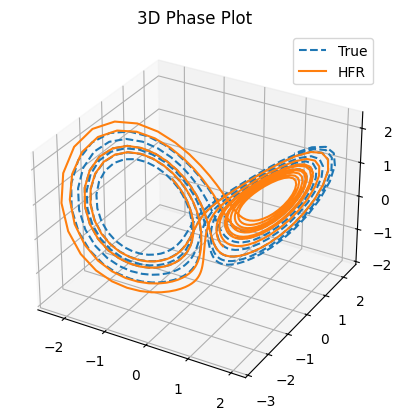

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2], label='True', linestyle='--')
# ax.plot(hfr_preds[:plot_len,0], hfr_preds[:plot_len,1], hfr_preds[:plot_len,2], label='HFR')
# ax.set_title('3D Phase Plot')
# ax.legend()
# plt.show()

In [ ]:
# # 3
# result = []
# step = 10
# for a in range(10, 141, step):  # max a = 140 to leave room for b and c
#     for b in range(a + step, 151, step):
#         c = 300 - a - b
#         if c > b and c % step == 0 and c <= 300:
#             result.append([a, b, c])

# print(result)
# print(f"Total unique combinations: {len(result)}")

[[10, 20, 270], [10, 30, 260], [10, 40, 250], [10, 50, 240], [10, 60, 230], [10, 70, 220], [10, 80, 210], [10, 90, 200], [10, 100, 190], [10, 110, 180], [10, 120, 170], [10, 130, 160], [10, 140, 150], [20, 30, 250], [20, 40, 240], [20, 50, 230], [20, 60, 220], [20, 70, 210], [20, 80, 200], [20, 90, 190], [20, 100, 180], [20, 110, 170], [20, 120, 160], [20, 130, 150], [30, 40, 230], [30, 50, 220], [30, 60, 210], [30, 70, 200], [30, 80, 190], [30, 90, 180], [30, 100, 170], [30, 110, 160], [30, 120, 150], [30, 130, 140], [40, 50, 210], [40, 60, 200], [40, 70, 190], [40, 80, 180], [40, 90, 170], [40, 100, 160], [40, 110, 150], [40, 120, 140], [50, 60, 190], [50, 70, 180], [50, 80, 170], [50, 90, 160], [50, 100, 150], [50, 110, 140], [50, 120, 130], [60, 70, 170], [60, 80, 160], [60, 90, 150], [60, 100, 140], [60, 110, 130], [70, 80, 150], [70, 90, 140], [70, 100, 130], [70, 110, 120], [80, 90, 130], [80, 100, 120], [90, 100, 110]]
Total unique combinations: 61


In [ ]:
# # 4
# result = []
# step = 10
# for a in range(10, 211, step):  # max a = 210
#     for b in range(a + step, 221, step):
#         for c in range(b + step, 231, step):
#             d = 300 - a - b - c
#             if d > c and d % step == 0 and d <= 300:
#                 result.append([a, b, c, d])

# print(result)
# print(f"Total unique combinations: {len(result)}")

[[10, 20, 30, 240], [10, 20, 40, 230], [10, 20, 50, 220], [10, 20, 60, 210], [10, 20, 70, 200], [10, 20, 80, 190], [10, 20, 90, 180], [10, 20, 100, 170], [10, 20, 110, 160], [10, 20, 120, 150], [10, 20, 130, 140], [10, 30, 40, 220], [10, 30, 50, 210], [10, 30, 60, 200], [10, 30, 70, 190], [10, 30, 80, 180], [10, 30, 90, 170], [10, 30, 100, 160], [10, 30, 110, 150], [10, 30, 120, 140], [10, 40, 50, 200], [10, 40, 60, 190], [10, 40, 70, 180], [10, 40, 80, 170], [10, 40, 90, 160], [10, 40, 100, 150], [10, 40, 110, 140], [10, 40, 120, 130], [10, 50, 60, 180], [10, 50, 70, 170], [10, 50, 80, 160], [10, 50, 90, 150], [10, 50, 100, 140], [10, 50, 110, 130], [10, 60, 70, 160], [10, 60, 80, 150], [10, 60, 90, 140], [10, 60, 100, 130], [10, 60, 110, 120], [10, 70, 80, 140], [10, 70, 90, 130], [10, 70, 100, 120], [10, 80, 90, 120], [10, 80, 100, 110], [20, 30, 40, 210], [20, 30, 50, 200], [20, 30, 60, 190], [20, 30, 70, 180], [20, 30, 80, 170], [20, 30, 90, 160], [20, 30, 100, 150], [20, 30, 110,

In [ ]:
# # 5
# result = []
# step = 10
# for a in range(10, 221, step):  # max a = 220 so sum of 5 increasing values doesn't exceed 300
#     for b in range(a + step, 231, step):
#         for c in range(b + step, 241, step):
#             for d in range(c + step, 251, step):
#                 e = 300 - a - b - c - d
#                 if e > d and e % step == 0 and e <= 300:
#                     result.append([a, b, c, d, e])

# print(result)
# print(f"Total unique combinations: {len(result)}")

[[10, 20, 30, 40, 200], [10, 20, 30, 50, 190], [10, 20, 30, 60, 180], [10, 20, 30, 70, 170], [10, 20, 30, 80, 160], [10, 20, 30, 90, 150], [10, 20, 30, 100, 140], [10, 20, 30, 110, 130], [10, 20, 40, 50, 180], [10, 20, 40, 60, 170], [10, 20, 40, 70, 160], [10, 20, 40, 80, 150], [10, 20, 40, 90, 140], [10, 20, 40, 100, 130], [10, 20, 40, 110, 120], [10, 20, 50, 60, 160], [10, 20, 50, 70, 150], [10, 20, 50, 80, 140], [10, 20, 50, 90, 130], [10, 20, 50, 100, 120], [10, 20, 60, 70, 140], [10, 20, 60, 80, 130], [10, 20, 60, 90, 120], [10, 20, 60, 100, 110], [10, 20, 70, 80, 120], [10, 20, 70, 90, 110], [10, 20, 80, 90, 100], [10, 30, 40, 50, 170], [10, 30, 40, 60, 160], [10, 30, 40, 70, 150], [10, 30, 40, 80, 140], [10, 30, 40, 90, 130], [10, 30, 40, 100, 120], [10, 30, 50, 60, 150], [10, 30, 50, 70, 140], [10, 30, 50, 80, 130], [10, 30, 50, 90, 120], [10, 30, 50, 100, 110], [10, 30, 60, 70, 130], [10, 30, 60, 80, 120], [10, 30, 60, 90, 110], [10, 30, 70, 80, 110], [10, 30, 70, 90, 100], [1

In [ ]:
# # 6
# result = []
# step = 5
# for a in range(10, 181, step):  # Max a = 180
#     for b in range(a + step, 191, step):
#         for c in range(b + step, 201, step):
#             for d in range(c + step, 211, step):
#                 for e in range(d + step, 221, step):
#                     f = 300 - a - b - c - d - e
#                     if f > e and f % step == 0 and f <= 300:
#                         result.append([a, b, c, d, e, f])

# print(result)
# print(f"Total unique combinations: {len(result)}")

[[10, 15, 20, 25, 30, 200], [10, 15, 20, 25, 35, 195], [10, 15, 20, 25, 40, 190], [10, 15, 20, 25, 45, 185], [10, 15, 20, 25, 50, 180], [10, 15, 20, 25, 55, 175], [10, 15, 20, 25, 60, 170], [10, 15, 20, 25, 65, 165], [10, 15, 20, 25, 70, 160], [10, 15, 20, 25, 75, 155], [10, 15, 20, 25, 80, 150], [10, 15, 20, 25, 85, 145], [10, 15, 20, 25, 90, 140], [10, 15, 20, 25, 95, 135], [10, 15, 20, 25, 100, 130], [10, 15, 20, 25, 105, 125], [10, 15, 20, 25, 110, 120], [10, 15, 20, 30, 35, 190], [10, 15, 20, 30, 40, 185], [10, 15, 20, 30, 45, 180], [10, 15, 20, 30, 50, 175], [10, 15, 20, 30, 55, 170], [10, 15, 20, 30, 60, 165], [10, 15, 20, 30, 65, 160], [10, 15, 20, 30, 70, 155], [10, 15, 20, 30, 75, 150], [10, 15, 20, 30, 80, 145], [10, 15, 20, 30, 85, 140], [10, 15, 20, 30, 90, 135], [10, 15, 20, 30, 95, 130], [10, 15, 20, 30, 100, 125], [10, 15, 20, 30, 105, 120], [10, 15, 20, 30, 110, 115], [10, 15, 20, 35, 40, 180], [10, 15, 20, 35, 45, 175], [10, 15, 20, 35, 50, 170], [10, 15, 20, 35, 55, 

In [ ]:
# 7
result = []
step = 5
for a in range(10, 151, step):  # max a = 150
    for b in range(a + step, 161, step):
        for c in range(b + step, 171, step):
            for d in range(c + step, 181, step):
                for e in range(d + step, 191, step):
                    for f in range(e + step, 201, step):
                        g = 300 - a - b - c - d - e - f
                        if g > f and g % step == 0 and g <= 300:
                            result.append([a, b, c, d, e, f, g])

print(result)
print(f"Total unique combinations: {len(result)}")

[[10, 15, 20, 25, 30, 35, 165], [10, 15, 20, 25, 30, 40, 160], [10, 15, 20, 25, 30, 45, 155], [10, 15, 20, 25, 30, 50, 150], [10, 15, 20, 25, 30, 55, 145], [10, 15, 20, 25, 30, 60, 140], [10, 15, 20, 25, 30, 65, 135], [10, 15, 20, 25, 30, 70, 130], [10, 15, 20, 25, 30, 75, 125], [10, 15, 20, 25, 30, 80, 120], [10, 15, 20, 25, 30, 85, 115], [10, 15, 20, 25, 30, 90, 110], [10, 15, 20, 25, 30, 95, 105], [10, 15, 20, 25, 35, 40, 155], [10, 15, 20, 25, 35, 45, 150], [10, 15, 20, 25, 35, 50, 145], [10, 15, 20, 25, 35, 55, 140], [10, 15, 20, 25, 35, 60, 135], [10, 15, 20, 25, 35, 65, 130], [10, 15, 20, 25, 35, 70, 125], [10, 15, 20, 25, 35, 75, 120], [10, 15, 20, 25, 35, 80, 115], [10, 15, 20, 25, 35, 85, 110], [10, 15, 20, 25, 35, 90, 105], [10, 15, 20, 25, 35, 95, 100], [10, 15, 20, 25, 40, 45, 145], [10, 15, 20, 25, 40, 50, 140], [10, 15, 20, 25, 40, 55, 135], [10, 15, 20, 25, 40, 60, 130], [10, 15, 20, 25, 40, 65, 125], [10, 15, 20, 25, 40, 70, 120], [10, 15, 20, 25, 40, 75, 115], [10, 15

In [ ]:
# # 8 (but not feasible for the case of step=10)
# result = []
# step = 5
# for a in range(10, 121, step):  # Conservative bounds to leave room
#     for b in range(a + step, 131, step):
#         for c in range(b + step, 141, step):
#             for d in range(c + step, 151, step):
#                 for e in range(d + step, 161, step):
#                     for f in range(e + step, 171, step):
#                         for g in range(f + step, 181, step):
#                             h = 300 - a - b - c - d - e - f - g
#                             if h > g and h % step == 0 and h <= 300:
#                                 result.append([a, b, c, d, e, f, g, h])

# print(result)
# print(f"Total unique combinations: {len(result)}")

[[10, 15, 20, 25, 30, 35, 40, 125], [10, 15, 20, 25, 30, 35, 45, 120], [10, 15, 20, 25, 30, 35, 50, 115], [10, 15, 20, 25, 30, 35, 55, 110], [10, 15, 20, 25, 30, 35, 60, 105], [10, 15, 20, 25, 30, 35, 65, 100], [10, 15, 20, 25, 30, 35, 70, 95], [10, 15, 20, 25, 30, 35, 75, 90], [10, 15, 20, 25, 30, 35, 80, 85], [10, 15, 20, 25, 30, 40, 45, 115], [10, 15, 20, 25, 30, 40, 50, 110], [10, 15, 20, 25, 30, 40, 55, 105], [10, 15, 20, 25, 30, 40, 60, 100], [10, 15, 20, 25, 30, 40, 65, 95], [10, 15, 20, 25, 30, 40, 70, 90], [10, 15, 20, 25, 30, 40, 75, 85], [10, 15, 20, 25, 30, 45, 50, 105], [10, 15, 20, 25, 30, 45, 55, 100], [10, 15, 20, 25, 30, 45, 60, 95], [10, 15, 20, 25, 30, 45, 65, 90], [10, 15, 20, 25, 30, 45, 70, 85], [10, 15, 20, 25, 30, 45, 75, 80], [10, 15, 20, 25, 30, 50, 55, 95], [10, 15, 20, 25, 30, 50, 60, 90], [10, 15, 20, 25, 30, 50, 65, 85], [10, 15, 20, 25, 30, 50, 70, 80], [10, 15, 20, 25, 30, 55, 60, 85], [10, 15, 20, 25, 30, 55, 65, 80], [10, 15, 20, 25, 30, 55, 70, 75], [

In [ ]:
cells_per_level_grid = {
    # "cells_per_level": [[300], [100, 200], [50, 100, 150], [40, 60, 80, 120], [25, 35, 50, 70, 120], [20, 30, 50, 60, 65, 75], [15, 25, 30, 40, 50, 60, 80], [5, 10, 25, 30, 40, 50, 60, 80]],
    "cells_per_level": result,
    "spectral_radius": [0.95],
    "input_scale": [0.2],
    "leaking_rate": [0.1],
    "ridge_alpha": [1e-8],
}

In [14]:
def run_grid_search(model_class, param_grid, model_name,
                    output_path="grid_search_results.json"):
    # Precompute param combinations
    combos = list(itertools.product(*param_grid.values()))
    param_keys = list(param_grid.keys())
    print(f"\n== Initial grid search for {model_name} with {len(combos)} combinations ==")

    results = []
    # tqdm adds a progress bar for better visualization
    for comb in tqdm(combos, desc="Grid Search"):
        params = dict(zip(param_keys, comb))
        seed_scores = []
        
        # Run all 20 seeds
        for seed in range(1, 21):
            model = model_class(**params, seed=seed)
            model.fit_readout(train_input, train_target, discard=100)
            preds = model.predict_autoregressive(initial_in, n_test_steps)
            T_VPT_s, _, _ = report_vpt("model", preds,
                                       test_target,
                                       t_vals[train_end:train_end+n_test_steps],
                                       dt)
            seed_scores.append(T_VPT_s)

        mean_score = float(np.mean(seed_scores))
        std_dev    = float(np.std(seed_scores))
        is_stable  = std_dev < 1.5
        status     = "Stable" if is_stable else "Unstable"
        
        # print(f"Params: {params} → Avg T_VPT={mean_score:.3f}, "
        #       f"Std Dev={std_dev:.3f} → {status}")

        results.append({
            "params":      params,
            "seed_scores": seed_scores,
            "mean_T_VPT":  mean_score,
            "std_dev":     std_dev,
            "stable":      is_stable
        })

    # Save results
    with open(output_path, "w") as f:
        json.dump(results, f, indent=2)
    print(f"\nAll results saved to `{output_path}`")
    
    return results

In [18]:
hfr_results = run_grid_search(HFRRes3D, cells_per_level_grid, "HFR")


== Initial grid search for HFR with 1 combinations ==


Grid Search:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shrey\AppData\Local\Progra


All results saved to `grid_search_results1.json`


In [ ]:
# # 5 allowing for duplicates
# result = []
# for a in range(10, 241, 10):  # a ≠ 0, a ≤ 240
#     for b in range(a, (300 - a) // 4 + 1, 10):
#         for c in range(b, (300 - a - b) // 3 + 1, 10):
#             for d in range(c, (300 - a - b - c) // 2 + 1, 10):
#                 e = 300 - a - b - c - d
#                 if e >= d and e % 10 == 0:
#                     result.append([a, b, c, d, e])

# print(result)
# print(f"Total unique combinations: {len(result)}")

[[10, 10, 10, 10, 260], [10, 10, 10, 20, 250], [10, 10, 10, 30, 240], [10, 10, 10, 40, 230], [10, 10, 10, 50, 220], [10, 10, 10, 60, 210], [10, 10, 10, 70, 200], [10, 10, 10, 80, 190], [10, 10, 10, 90, 180], [10, 10, 10, 100, 170], [10, 10, 10, 110, 160], [10, 10, 10, 120, 150], [10, 10, 10, 130, 140], [10, 10, 20, 20, 240], [10, 10, 20, 30, 230], [10, 10, 20, 40, 220], [10, 10, 20, 50, 210], [10, 10, 20, 60, 200], [10, 10, 20, 70, 190], [10, 10, 20, 80, 180], [10, 10, 20, 90, 170], [10, 10, 20, 100, 160], [10, 10, 20, 110, 150], [10, 10, 20, 120, 140], [10, 10, 20, 130, 130], [10, 10, 30, 30, 220], [10, 10, 30, 40, 210], [10, 10, 30, 50, 200], [10, 10, 30, 60, 190], [10, 10, 30, 70, 180], [10, 10, 30, 80, 170], [10, 10, 30, 90, 160], [10, 10, 30, 100, 150], [10, 10, 30, 110, 140], [10, 10, 30, 120, 130], [10, 10, 40, 40, 200], [10, 10, 40, 50, 190], [10, 10, 40, 60, 180], [10, 10, 40, 70, 170], [10, 10, 40, 80, 160], [10, 10, 40, 90, 150], [10, 10, 40, 100, 140], [10, 10, 40, 110, 130